In [1]:
import os
import sys
import re
from pathlib import Path
from collections import defaultdict
from itertools import combinations

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, ks_2samp, friedmanchisquare, kruskal
from statsmodels.stats.multitest import multipletests

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.x_to_a import commonly_expressed

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq-wf/scrnaseq_combine_force')

last updated: 2018-11-02 
Git hash:


In [3]:
cluster_annot = {
    0: 'LS',
    1: 'MC',
    2: 'MS',
    3: 'ES',
    4: 'LC',
    5: 'EC',
    6: 'SP',
    7: 'TE',
    8: 'PC',
}

cluster_order = [
    'SP',
    'ES',
    'MS',
    'LS',
    'EC',
    'MC',
    'LC',
    'TE',
    'PC',
]

clusters = nbconfig.seurat.get_clusters('res.0.6')
clusters = clusters[(clusters != 9) & (clusters != 10) & (clusters != 11)].copy()
clusters = clusters.map(cluster_annot)
clusters = pd.Series(pd.Categorical(clusters.values, categories=cluster_order, ordered=True), index=pd.Index(clusters.index, name='cell_id'), name='cluster').to_frame()
clusters['rep'] = clusters.index.str.extract('(rep\d)_').values.flatten()

In [4]:
chroms = nbconfig.fbgn2chrom.query('chrom != "chrY" & chrom != "chrM" & chrom != "chr4"').copy()
chroms.chrom = chroms.chrom.astype('category')
chroms.chrom = chroms.chrom.cat.reorder_categories(nbconfig.chrom_order[:-2])

In [31]:
autosomes = ['chr2L', 'chr2R', 'chr3L', 'chr3R']

In [92]:
xa = chroms.copy()
xa.chrom = xa.chrom.astype(str)
xa.loc[xa.chrom.isin(autosomes), 'chrom'] = 'A'
xa.loc[xa.chrom == 'chrX', 'chrom'] = 'X'
xa = xa.chrom.astype('category')
xa = xa.cat.reorder_categories(['X', 'A'])
xa = xa.cat.as_ordered()

In [5]:
norm = nbconfig.seurat.get_normalized_read_counts()

In [6]:
norm = norm.reindex(commonly_expressed(data=norm))

In [7]:
def prop_on(x):
    return x.sum() / x.shape[0]


def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    
    return perm_sample_1, perm_sample_2


def statistic(data1, data2, test='ks'):
    if test == 'ks':
        stat, _ = ks_2samp(data1, data2)
    elif test == 'mann':
        stat, _ = mannwhitneyu(data1, data2)
        
    return stat


def draw_perm_reps(data1, data2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

In [8]:
def _run1(cluster, rep, dat):
    prop_genes_on = (dat > 0).join(chroms).groupby('chrom').agg(prop_on).T
    
    
    # Permutation test for each pairwise chromosome get stats
    pvals = list()
    cbn = list(combinations(prop_genes_on.columns, 2))
    for c1, c2 in cbn:
        _d1 = prop_genes_on[c1]
        _d2 = prop_genes_on[c2]
        
        obs = statistic(_d1, _d2)
        perms = draw_perm_reps(_d1, _d2, func=statistic, size=1_000)
        pval = np.sum(perms >= obs) / len(perms)
        pvals.append((c1, c2, pval))
    
    return pvals


results = []
for (clus, rep), dd in clusters.groupby(['cluster', 'rep']):
    _dat = norm.reindex(columns=dd.index)
    for res in _run1(clus, rep, _dat):
        results.append([clus, rep, *res])

df = pd.DataFrame(results, columns=['cluster', 'rep', 'chrom1', 'chrom2', 'p-value'])
wide = df.pivot_table(index=['cluster', 'chrom1', 'chrom2'], columns='rep', values='p-value')

In [9]:
print('SP')
display(wide.loc['SP'])

print('MC')
display(wide.loc['MC'])

print('MS')
display(wide.loc['MS'])

SP


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.329  0.480  0.692
       chr3L   0.117  0.347  0.204
       chr3R   0.075  0.042  0.007
chr2R  chr3L   0.642  0.746  0.370
       chr3R   0.636  0.213  0.067
chr3L  chr3R   0.816  0.268  0.021
chrX   chr2L   0.045  0.255  0.014
       chr2R   0.384  0.847  0.050
       chr3L   0.972  0.678  0.281
       chr3R   0.904  0.119  0.000

MC


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.000  0.006  0.396
       chr3L   0.000  0.001  0.000
       chr3R   0.000  0.083  0.000
chr2R  chr3L   0.000  0.000  0.000
       chr3R   0.000  0.000  0.000
chr3L  chr3R   0.005  0.077  0.000
chrX   chr2L   0.002  0.044  0.000
       chr2R   0.026  0.363  0.000
       chr3L   0.000  0.000  0.010
       chr3R   0.000  0.001  0.001

MS


rep             rep1   rep2   rep3
chrom1 chrom2                     
chr2L  chr2R   0.036  0.390  0.000
       chr3L   0.000  0.022  0.000
       chr3R   0.002  0.280  0.000
chr2R  chr3L   0.003  0.653  0.000
       chr3R   0.733  0.929  0.962
chr3L  chr3R   0.020  0.523  0.001
chrX   chr2L   0.000  0.000  0.000
       chr2R   0.000  0.000  0.000
       chr3L   0.013  0.000  0.000
       chr3R   0.000  0.000  0.000

In [10]:
def _run2(cluster, rep, dat):
    prop_genes_on = (dat > 0).join(chroms).groupby('chrom').agg(prop_on).T
    _med = prop_genes_on[['chr2L', 'chr2R', 'chr3L', 'chr3R']].median(axis=1)
    
    # Permutation test for each chromosome to median Autosome
    pvals = list()
    cbn = list(combinations(prop_genes_on.columns, 2))
    for chrom in prop_genes_on.columns:
        _d1 = prop_genes_on[chrom]
        _d2 = _med
        
        obs = statistic(_d1, _d2)
        perms = draw_perm_reps(_d1, _d2, func=statistic, size=1_000)
        pval = np.sum(perms >= obs) / len(perms)
        pvals.append((chrom, pval))
    
    return pvals


results = []
for (clus, rep), dd in clusters.groupby(['cluster', 'rep']):
    _dat = norm.reindex(columns=dd.index)
    for res in _run2(clus, rep, _dat):
        results.append([clus, rep, *res])

df = pd.DataFrame(results, columns=['cluster', 'rep', 'chrom', 'p-value'])
df['q-value'] = multipletests(df['p-value'], method='fdr_bh')[1]
wide = df.pivot_table(index=['cluster', 'chrom'], columns='rep', values='q-value')

In [11]:
print('SP')
display(wide.loc['SP'])

print('MC')
display(wide.loc['MC'])

print('MS')
display(wide.loc['MS'])

SP


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.385435,0.822135,0.670120
chr2R,1.000000,1.000000,0.955093
chr3L,1.000000,1.000000,0.461842
chr3R,1.000000,0.329062,0.416096
chrX,0.907660,0.919853,0.077143


MC


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.385986,0.732176,0.009643
chr2R,0.000000,0.005000,0.000000
chr3L,0.000000,0.023143,0.000000
chr3R,0.079412,0.633333,0.077143
chrX,0.000000,0.077143,0.000000


MS


rep,rep1,rep2,rep3
chrom,,,
chr2L,0.048462,0.633333,0.000000
chr2R,1.000000,1.000000,0.919853
chr3L,0.023143,0.827609,0.000000
chr3R,1.000000,1.000000,1.000000
chrX,0.000000,0.000000,0.000000


In [124]:
raw.head()

cell_id,rep1_AAACCTGAGACAAGCC,rep1_AAACCTGAGCTTATCG,rep1_AAACCTGGTGTAATGA,rep1_AAACCTGGTTCATGGT,rep1_AAACCTGTCCCTCTTT,rep1_AAACGGGAGACTGGGT,rep1_AAACGGGCACAGTCGC,rep1_AAACGGGGTCGCGTGT,rep1_AAACGGGGTGTTAAGA,rep1_AAACGGGTCGTCCAGG,...,rep3_TTTGTCACAGTCACTA,rep3_TTTGTCACATTTCAGG,rep3_TTTGTCAGTACATGTC,rep3_TTTGTCAGTACCCAAT,rep3_TTTGTCAGTGGACGAT,rep3_TTTGTCATCATAAAGG,rep3_TTTGTCATCATGGTCA,rep3_TTTGTCATCCCTTGTG,rep3_TTTGTCATCTCCGGTT,rep3_TTTGTCATCTTGCAAG
FBgn,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,0,0,0,2,0,0,0,0,0,0,...,0,2,0,0,1,1,1,2,0,0
FBgn0040784,0,0,0,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
FBgn0031086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
raw = nbconfig.seurat.get_raw()
_on = raw.sum(axis=1) > (raw.shape[1] / 3)

genes_on = pd.concat([_on, xa], axis=1, sort=True).groupby('chrom').sum().iloc[:, 0]
genes_on.name = 'genes_on'

counts = pd.concat([raw, xa], axis=1, sort=True).groupby('chrom').sum()
counts.name = 'cnts'
scaled_count = counts.div(genes_on, axis='index').T

ratio = scaled_count['X'] / scaled_count['A']
ratio.name = 'x2a'

In [135]:
_dat = pd.concat([ratio, clusters], sort=True, axis=1).dropna()

In [136]:
_dat.head()

,x2a,cluster,rep
rep1_AAACCTGAGACAAGCC,1.029357,MC,rep1
rep1_AAACCTGAGCTTATCG,1.564391,MC,rep1
rep1_AAACCTGGTGTAATGA,1.273144,EC,rep1
rep1_AAACCTGGTTCATGGT,0.595936,MS,rep1
rep1_AAACCTGTCCCTCTTT,1.213557,MC,rep1


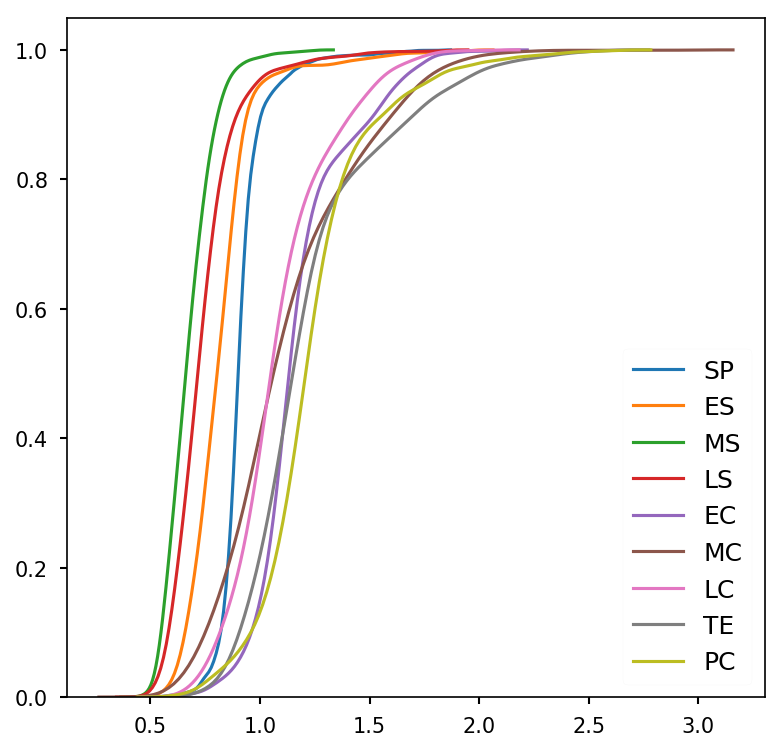

In [138]:
for c, dd in _dat.groupby('cluster'):
    sns.kdeplot(dd.x2a, cumulative=True, label=c)

In [406]:
def stat2(dat):
    obs = dat['obs_ratio']
    lt = 0
    cnt = 0
    for perm in dat.iloc[:, 1:].values.T:
        _, p = mannwhitneyu(obs, perm, alternative='less')
        if p <= 0.01:
            lt += 1
        cnt += 1
    pvalue = 1 - lt / cnt
    return pvalue

def level1(rep):
    # Rep level
    # Decide what genes are expressed and pull out raw counts
    _raw = raw.reindex(columns=clusters.index[clusters.rep == rep])
    genes_on = _raw.sum(axis=1) > (_raw.shape[1] / 3)
    _raw_on = _raw[genes_on]

    # Create a list of Autosomal and X linked genes based on the ones expressed
    # The perumutation test can perumte X/A and then calculate
    _xa = xa.reindex(_raw_on.index)
    _X = _xa.index[_xa == 'X'].tolist()
    _A = _xa.index[_xa == 'A'].tolist()
    
    results = {}
    for cluster, dd in clusters[clusters.rep == rep].groupby('cluster'):
        ratios = []
        _cluster_cells = dd.index
        _raw_on_cluster = _raw_on.reindex(columns=_cluster_cells)
        _X_cluster_scaled = _raw_on_cluster.reindex(_X).sum() / len(_X)
        _A_cluster_scaled = _raw_on_cluster.reindex(_A).sum() / len(_A)
        obs_ratio = _X_cluster_scaled.div(_A_cluster_scaled)
        obs_ratio.name = 'obs_ratio'
        ratios.append(obs_ratio)

        for i in range(1_000):
            pX, pA = permutation_sample(_X, _A)
            pX_cluster_scaled = _raw_on_cluster.reindex(pX).sum() / len(pX)
            pA_cluster_scaled = _raw_on_cluster.reindex(pA).sum() / len(pA)
            permuted_ratio = pX_cluster_scaled.div(pA_cluster_scaled)
            permuted_ratio.name = f'perm{i}'
            ratios.append(permuted_ratio)

        results[cluster] = pd.concat(ratios, axis=1, sort=True)
        
    return results

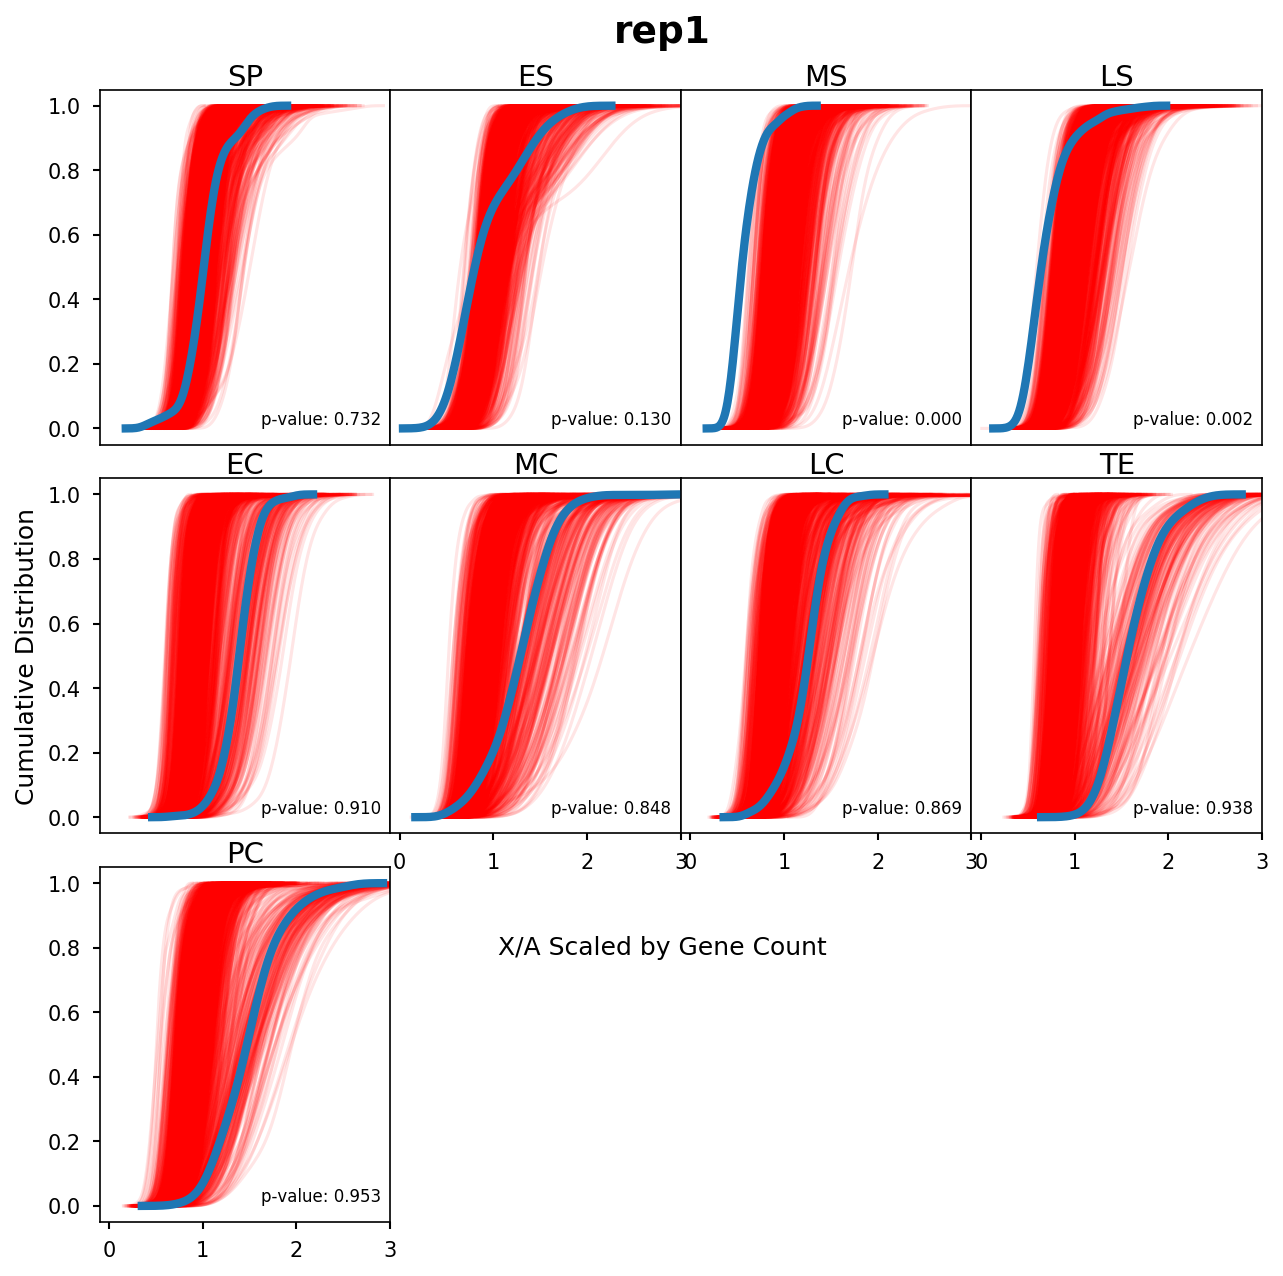

In [407]:
rep = 'rep1'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

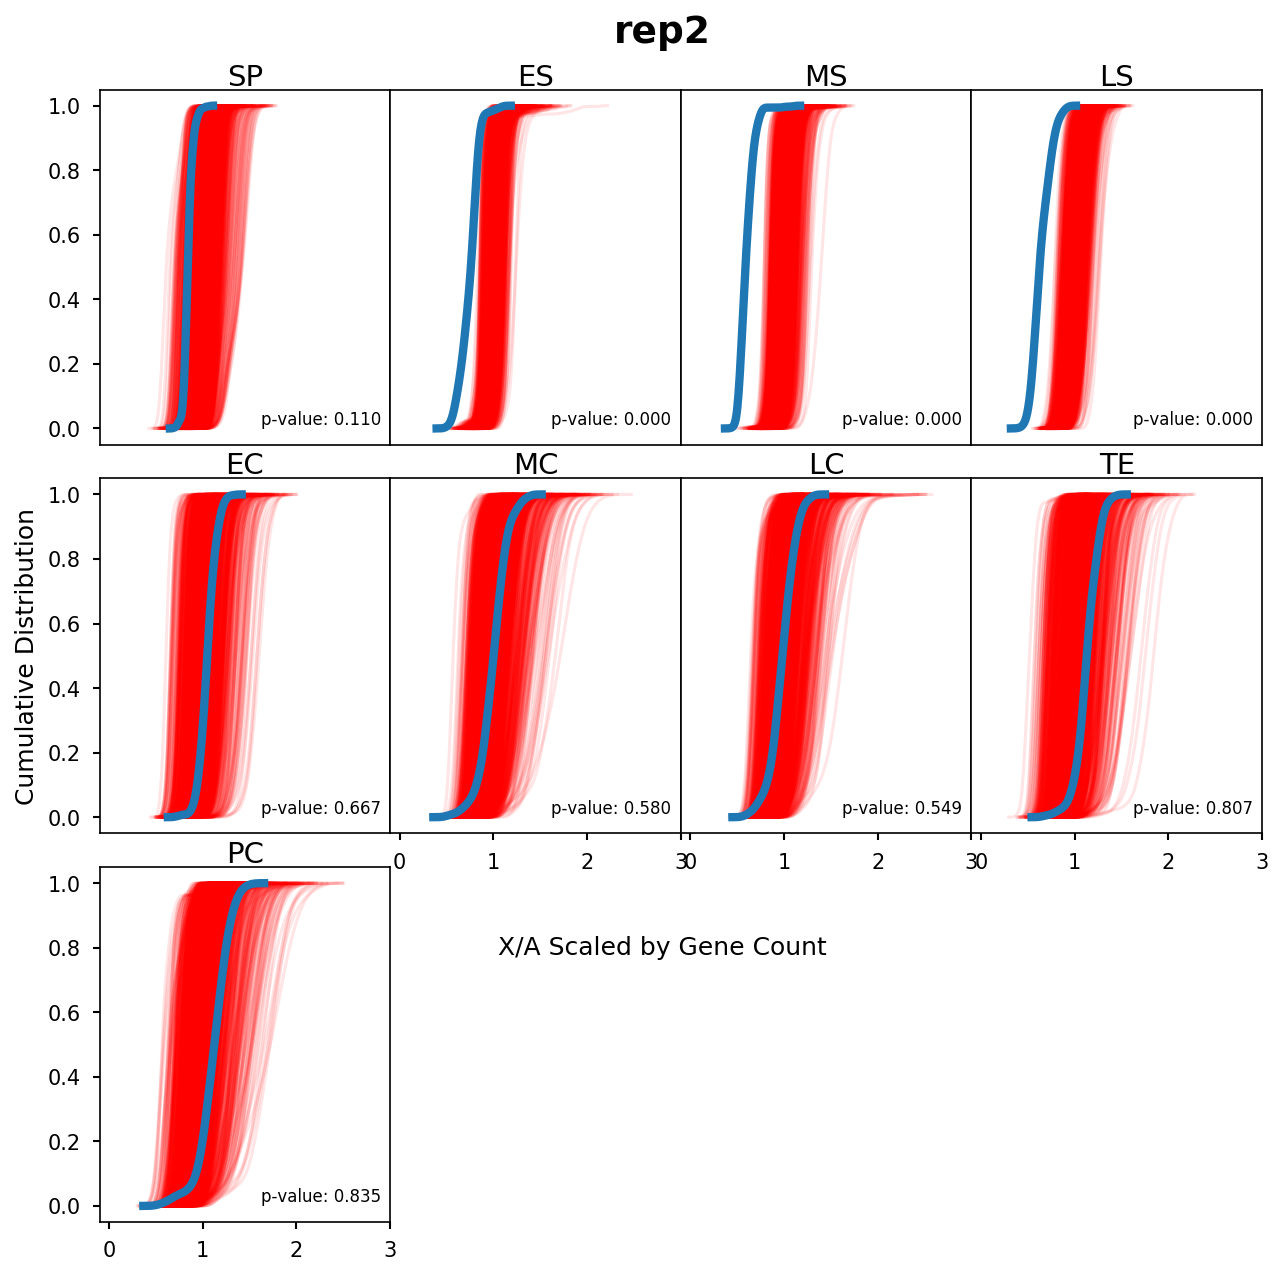

In [408]:
rep = 'rep2'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

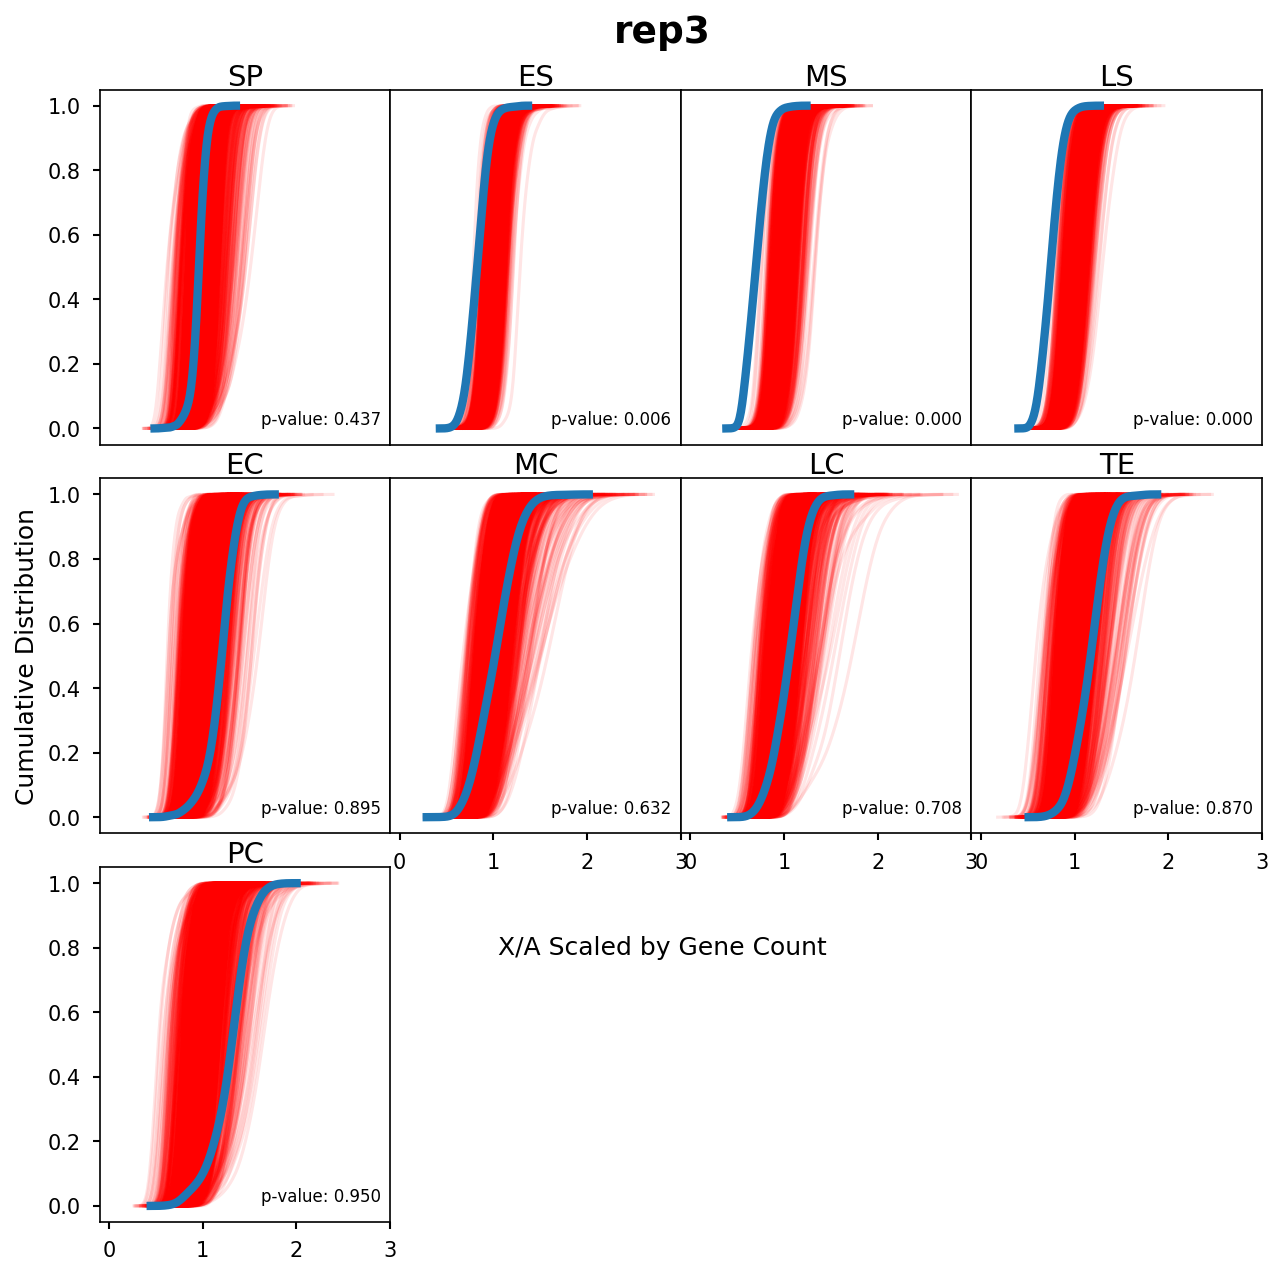

In [409]:
rep = 'rep3'
res = level1(rep)

fig, axes = plt.subplots(3, 4, figsize=(10, 10), gridspec_kw=dict(wspace=0, hspace=.095))

for ax, (k, val) in zip(axes.flatten(), res.items()):
    pvalue = stat2(val)
    ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
    for i, dd in val.iteritems():
        if i == 'obs_ratio':
            sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
        else:
            sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
    ax.set_title(k, va='center')

# Set limits
for ax in axes.flatten():
    ax.set_xlim(-.1, 3)
    ax.set_ylim(-0.05, 1.05)
    
# cleanup xaxis
for ax in axes[0, :].flatten():
    ax.xaxis.set_visible(False)
axes[1, 0].xaxis.set_visible(False)

# cleanup yaxis
for ax in axes[:, 1:].flatten():
    ax.yaxis.set_visible(False)
    
# remove extra plots
for ax in axes[-1, 1:].flatten():
    ax.set_visible(False)
    
# Add labels and title
axes[1, 0].set_ylabel('Cumulative Distribution')
fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
fig.suptitle(rep, y=.93, fontsize=18);

# Bulk

In [517]:
def level2(dat):
    # Decide what genes are expressed and pull out raw counts
    genes_on = (dat > 0).sum(axis=1) >= (dat.shape[1] / 3)
    dat_on = dat[genes_on].copy()

    # Create a list of Autosomal and X linked genes based on the ones expressed
    # The perumutation test can perumte X/A and then calculate
    _xa = xa.reindex(dat_on.index)
    _X = _xa.index[_xa == 'X'].tolist()
    _A = _xa.index[_xa == 'A'].tolist()
    
    ratios = []
    dat_on_X = dat_on.reindex(_X)
    dat_on_A = dat_on.reindex(_A)

    scaled_dat_on_X = dat_on_X.sum() / dat_on_X.shape[0]
    scaled_dat_on_A = dat_on_A.sum() / dat_on_A.shape[0]

    obs_ratio = scaled_dat_on_X / scaled_dat_on_A
    obs_ratio.name = 'obs_ratio'

    ratios.append(obs_ratio)

    for i in range(100):
        pX, pA = permutation_sample(_X, _A)
        pX_scaled = dat_on.reindex(pX).sum() / len(pX)
        pA_scaled = dat_on.reindex(pA).sum() / len(pA)
        permuted_ratio = pX_scaled.div(pA_scaled)
        permuted_ratio.name = f'perm{i}'
        ratios.append(permuted_ratio)

    return pd.concat(ratios, axis=1, sort=True)

In [524]:
bulk = pd.read_parquet('../output/bulk-rnaseq-wf/aggregation/gene_level_counts.parquet')
bulk = bulk[~bulk.index.str.startswith('ERCC')].copy()

Text(0.5,1,'C4_TDT')

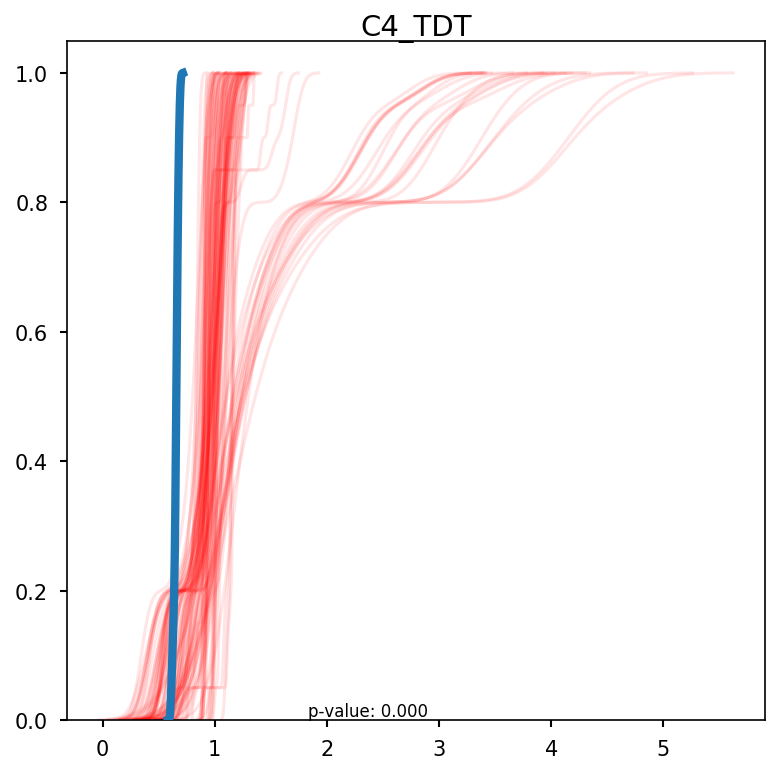

In [525]:
res = level2(bulk)
pvalue = stat2(res)

fig, ax = plt.subplots()
ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
for i, dd in res.iteritems():
    if i == 'obs_ratio':
        sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
    else:
        sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
ax.set_title(k, va='center')

# Add labels and title
#axes[1, 0].set_ylabel('Cumulative Distribution')
#fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
#fig.suptitle(rep, y=.93, fontsize=18);

In [526]:
bulk = pd.read_parquet('/home/fearjm/Projects/larval_gonad_ovary/output/bulk-wf/aggregation/featurecounts.parquet')
bulk = bulk[~bulk.index.str.startswith('ERCC')].copy()

Text(0.5,1,'C4_TDT')

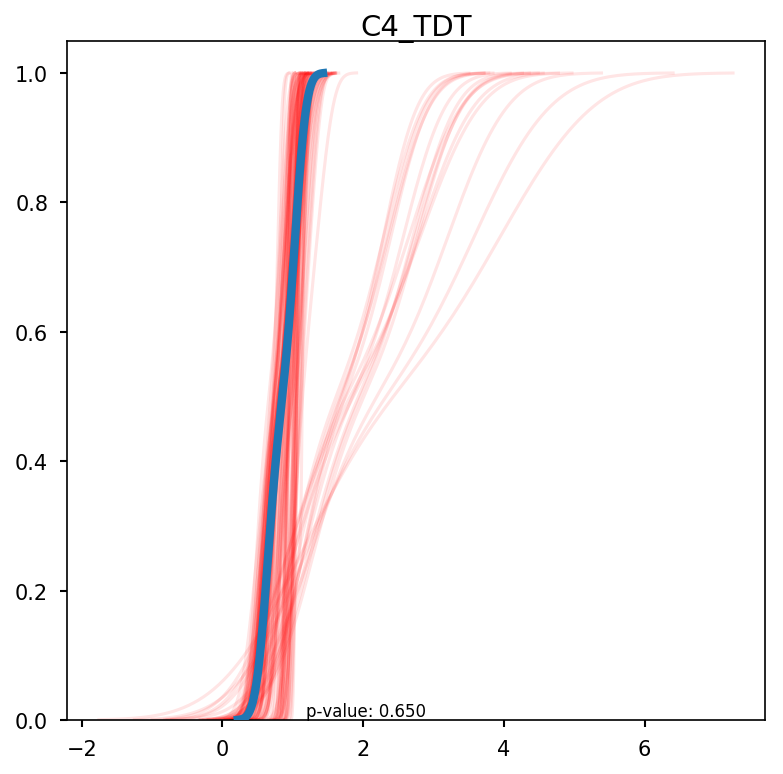

In [527]:
res = level2(bulk)
pvalue = stat2(res)

fig, ax = plt.subplots()
ax.text(2.9, 0, f'p-value: {pvalue:0.3f}', fontsize=8, ha='right', va='bottom')
for i, dd in res.iteritems():
    if i == 'obs_ratio':
        sns.kdeplot(dd, cumulative=True, legend=None, ax=ax, lw=4, zorder=10)
    else:
        sns.kdeplot(dd, cumulative=True, color='r', alpha=.1, legend=None, ax=ax, zorder=1)
ax.set_title(k, va='center')

# Add labels and title
#axes[1, 0].set_ylabel('Cumulative Distribution')
#fig.text(.5, .3, 'X/A Scaled by Gene Count', ha='center', va='bottom', fontsize=12)
#fig.suptitle(rep, y=.93, fontsize=18);